## Part 2

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score

from tqdm import tqdm

In [ ]:

data = pd.read_csv('./Dataset_a5/Dataset1/marketing_campaign_preprocessed.csv')

# label encoding
label_encoder = LabelEncoder()
data['Education'] = label_encoder.fit_transform(data['Education'])
data['Marital_Status'] = label_encoder.fit_transform(data['Marital_Status'])

data = data.drop(columns=['ID', 'Dt_Customer', 'Year_Birth', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'])

# scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Total_Spending']])
data_scaled = np.concatenate((data_scaled, data[['Education', 'Marital_Status']]), axis=1)

data_preprocessed = pd.DataFrame(data_scaled, columns=['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Total_Spending', 'Education', 'Marital_Status'])
data_preprocessed

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Total_Spending,Education,Marital_Status
0,0.287689,0.309118,0.352174,1.427120,2.506603,-0.555083,0.692301,1.017915,1.676120,2.0,3.0
1,-0.260057,-0.382230,-0.167612,-1.125249,-0.570823,-1.169892,-0.133077,1.274437,-0.962274,2.0,3.0
2,0.913505,-0.797039,-0.687398,1.427120,-0.228887,1.289346,-0.545767,0.333858,0.280592,2.0,4.0
3,-1.174887,-0.797039,-0.167612,-0.760624,-0.912759,-0.555083,0.279612,-1.290779,-0.919130,2.0,4.0
4,0.294887,1.553545,1.391746,0.333248,0.113050,0.059727,-0.133077,-1.034258,-0.306824,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2203,0.430965,-0.105691,-0.167612,1.791745,0.113050,-0.555083,-0.133077,0.162843,1.218135,2.0,2.0
2204,0.560586,0.239984,2.431318,1.427120,-0.228887,-0.247678,0.692301,1.958494,-0.270317,4.0,4.0
2205,0.233954,1.449843,-0.687398,-0.760624,0.113050,2.211560,0.279612,-1.034258,1.052198,2.0,1.0
2206,0.803529,-1.419252,-0.167612,0.697872,0.796922,1.289346,-0.958456,1.103422,0.391770,3.0,4.0


In [19]:
class KMeansScratch:
    def __init__(self, k, max_iters=100, tolerance=1e-4, n_init=5):
        self.k = k
        self.max_iters = max_iters
        self.tolerance = tolerance
        self.n_init = n_init
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, data):
        n_samples, n_features = data.shape
        best_inertia = float('inf')
        best_labels = None
        best_centroids = None

        for _ in range(self.n_init): 
            self.centroids = data[np.random.choice(n_samples, self.k, replace=False)]

            for i in range(self.max_iters):
                # Assign clusters based on closest centroid
                clusters = self._create_clusters(data)
                
                # Calculate new centroids
                new_centroids = np.array([data[clusters == j].mean(axis=0) for j in range(self.k)])
            
                # Check for convergence
                if np.all(np.abs(new_centroids - self.centroids) < self.tolerance):
                    break
                self.centroids = new_centroids

            # Update labels_ and inertia_ after each iteration
            self.labels_ = self._create_clusters(data)  
            self.inertia_ = self.inertia(data)  # Calculate and store inertia

            if self.inertia_ < best_inertia:
                best_inertia = self.inertia_
                best_labels = self.labels_
                best_centroids = self.centroids

        # Assign the best found labels, centroids, and inertia at the end of the loop
        self.labels_ = best_labels
        self.centroids = best_centroids 
        self.inertia_ = best_inertia

    def _create_clusters(self, data):
        return np.array([self._closest_centroid(data_point) for data_point in data])

    def _closest_centroid(self, data_point):
        distances = [np.linalg.norm(data_point - centroid) for centroid in self.centroids]
        return np.argmin(distances)

    def predict(self, data):
        return np.array([self._closest_centroid(data_point) for data_point in data])

    def inertia(self, data):
        return np.sum([np.linalg.norm(data_point - self.centroids[cluster]) ** 2 for data_point, cluster in zip(data, self.labels_)])

In [ ]:
k_values = [2, 3, 5, 7, 9]
inertia_scores = {}
silhouette_scores = {}

for k in tqdm(k_values):
    kmeans = KMeansScratch(k=k)
    kmeans.fit(data_preprocessed.values)
    inertia_scores[k] = kmeans.inertia_
    silhouette_scores[k] = silhouette_score(data_preprocessed.values, kmeans.labels_)


100%|██████████| 5/5 [00:44<00:00,  8.81s/it]


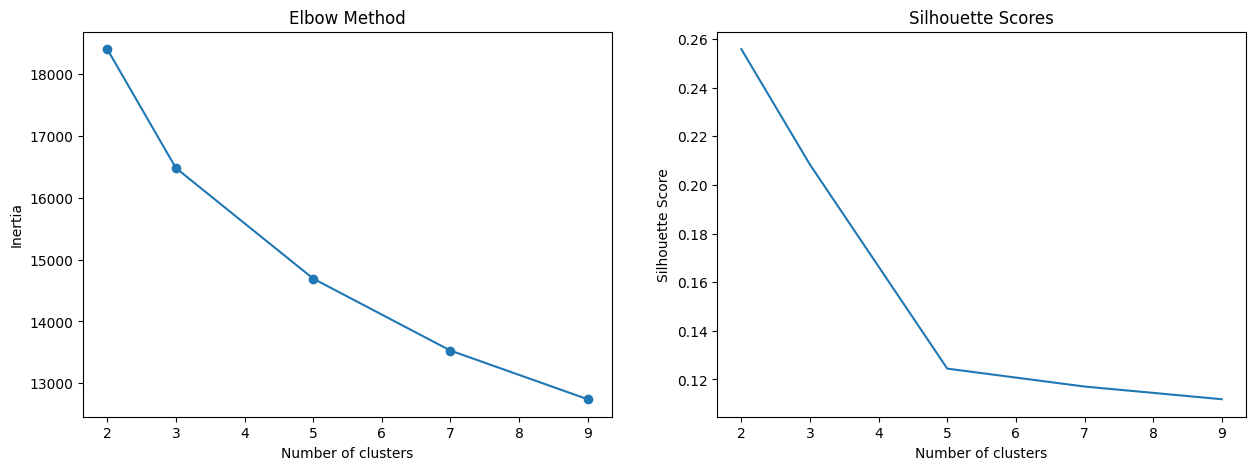

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(list(inertia_scores.keys()), list(inertia_scores.values()), marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette Score')

plt.show()


Elbow seems to be at `k=3`, and the silhouette score is also pretty high at `k=3`.

In [32]:
kmeans = KMeansScratch(k=3)
kmeans.fit(data_preprocessed.values)

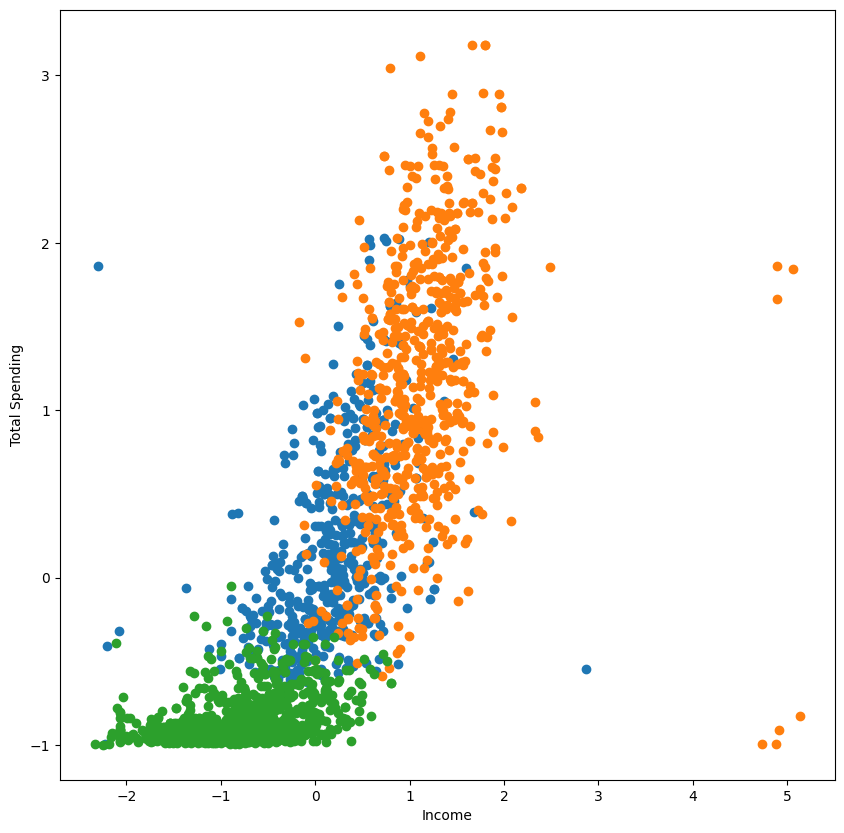

In [33]:
# plot the clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Income')
ax.set_ylabel('Total Spending')
for cluster in range(5):
    cluster_data = data_preprocessed[kmeans.labels_ == cluster]
    ax.scatter(cluster_data['Income'], cluster_data['Total_Spending'], label=f'Cluster {cluster + 1}')

Analyzing the clusters

Here, we are looking at the clusters from the point of view of two of the features, `Income` and `Total Spending`. We can clearly see how the clusters are well defined as those with similar `Income` and `Total Spending` are grouped together.